In [22]:
#Author#
#Sayantan Mukhopadhyay#
#10800120105#
#CSE#
#!pip install mtcnn

In [23]:
#Author#
#Sayantan Mukhopadhyay#
#10800120105#
#CSE#

import numpy as np
#from mtcnn.mtcnn import MTCNN
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import csv
import cv2
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.utils import to_categorical
from keras.applications import VGG16
from keras.optimizers import Adam
from keras.models import load_model
print(os.listdir("/kaggle/input"))

['xmlfile', 'input-data', 'input-test']


In [24]:
# Specify the root directory of your dataset
dataset_root ='/kaggle/input/input-data/Kin+O-1'

# Specify the kinship categories
kinship_categories = ['father-daughter', 'father-son', 'mother-dau', 'mother-son']

# Create a CSV file for the dataset
csv_filename = '/kaggle/working/Kinship_datasheet.csv'

# Open the CSV file in write mode
with open(csv_filename, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)

    # Write the header row with column names
    csv_writer.writerow(['Image_Path', 'Kinship_Label'])

    # Traverse through each kinship category
    for category in kinship_categories:
        category_path = os.path.join(dataset_root, category)

        # Get a list of image files in the current category
        image_files = [f for f in os.listdir(category_path) if f.endswith('.jpg') or f.endswith('.png')]

        # Assign a label based on the kinship category
        label = kinship_categories.index(category)

        # Write rows to the CSV file with image paths and labels
        for image_file in image_files:
            image_path = os.path.join(category_path, image_file)
            csv_writer.writerow([image_path, label])

print(f"CSV file '{csv_filename}' created successfully.")

CSV file '/kaggle/working/Kinship_datasheet.csv' created successfully.


In [25]:
csv_filename = '/kaggle/working/Kinship_datasheet.csv'

# Read the CSV file into a Pandas DataFrame
df = pd.read_csv(csv_filename)

# Display the first few rows of the DataFrame
print(df.head())

                                          Image_Path  Kinship_Label
0  /kaggle/input/input-data/Kin+O-1/father-daught...              0
1  /kaggle/input/input-data/Kin+O-1/father-daught...              0
2  /kaggle/input/input-data/Kin+O-1/father-daught...              0
3  /kaggle/input/input-data/Kin+O-1/father-daught...              0
4  /kaggle/input/input-data/Kin+O-1/father-daught...              0


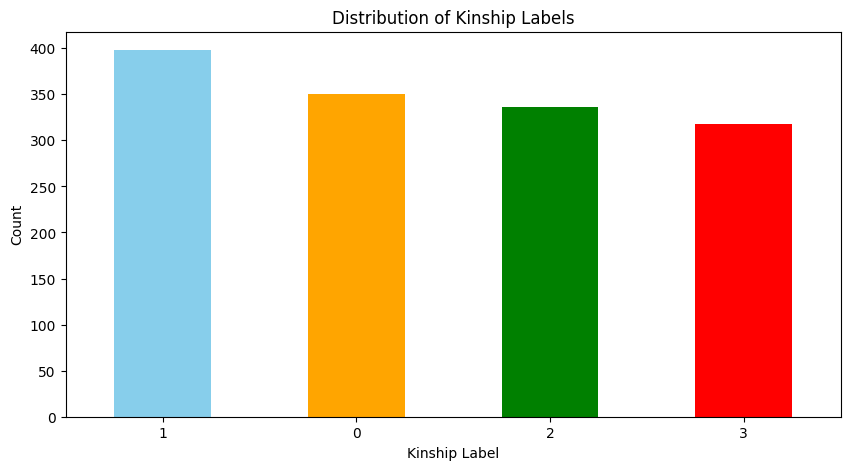

In [26]:
plt.figure(figsize=(10, 5))
df['Kinship_Label'].value_counts().plot(kind='bar', color=['skyblue', 'orange', 'green', 'red'])
plt.title('Distribution of Kinship Labels')
plt.xlabel('Kinship Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

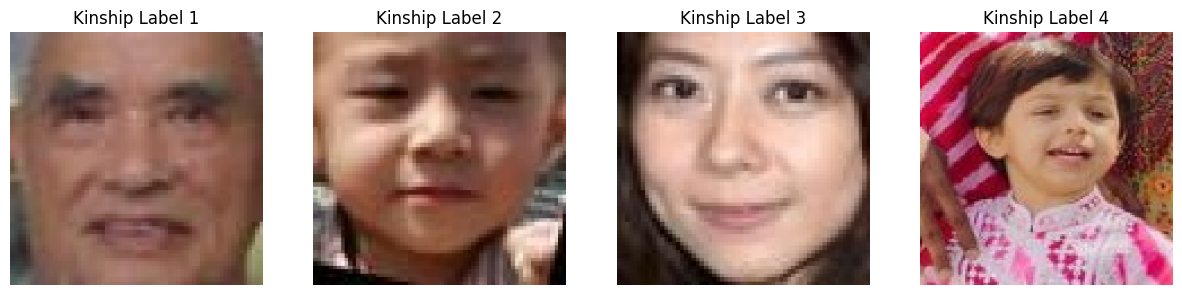

In [27]:
sample_images = []
for kinship_label in df['Kinship_Label'].unique():
    sample_image_path = df[df['Kinship_Label'] == kinship_label]['Image_Path'].iloc[0]
    sample_image = load_img(sample_image_path, target_size=(224, 224))
    sample_images.append(np.array(sample_image))

# Display the average face for each kinship label
plt.figure(figsize=(15, 5))
for i, image_array in enumerate(sample_images, 1):
    plt.subplot(1, 4, i)
    plt.imshow(image_array)
    plt.title(f'Kinship Label {i}')
    plt.axis('off')
plt.show()

In [28]:
# Split the dataset into training and testing sets
image_size = (224, 224)  # Set the desired image size
images = [img_to_array(load_img(path, target_size=image_size)) for path in df['Image_Path']]
images = np.array(images) / 255.0
labels = df['Kinship_Label']

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)


In [29]:
#num_classes = len(df['Kinship_Label'].unique())
#y_train_one_hot = to_categorical(y_train, num_classes)
#y_test_one_hot = to_categorical(y_test, num_classes)

# Label encoding
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Convert labels to one-hot encoding
num_classes = len(label_encoder.classes_)
y_train_one_hot = to_categorical(y_train_encoded, num_classes)
y_test_one_hot = to_categorical(y_test_encoded, num_classes)

# Display the shapes of the training and testing sets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train_one_hot.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test_one_hot.shape}")

X_train shape: (1121, 224, 224, 3), y_train shape: (1121, 4)
X_test shape: (281, 224, 224, 3), y_test shape: (281, 4)


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

In [30]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest")

# Apply data augmentation to the training set
datagen.fit(X_train)

In [31]:
#Author#
#Sayantan Mukhopadhyay#
#10800120105#
#CSE#
from keras.applications import VGG16
from keras.models import Model
from keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from keras.layers import Input

In [32]:
from keras.callbacks import LearningRateScheduler

# Define a learning rate schedule
def lr_schedule(epoch):
    if epoch < 50:
        return 1e-5
    elif epoch < 100:
        return 1e-6
    else:
        return 1e-7

In [33]:

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = True

model = Sequential()
model.add(base_model)
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
lr_scheduler = LearningRateScheduler(lr_schedule)
# Train the model with augmented data
history = model.fit(datagen.flow(X_train, y_train_one_hot, batch_size=42),
                    epochs=150,
                    validation_data=(X_test, y_test_one_hot),
                    callbacks=[early_stop, lr_scheduler])
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test_one_hot)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 conv2d_100 (Conv2D)         (None, 7, 7, 512)         2359808   
                                                                 
 conv2d_101 (Conv2D)         (None, 7, 7, 512)         2359808   
                                                                 
 conv2d_102 (Conv2D)         (None, 7, 7, 512)         2359808   
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 3, 3, 512)         0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 4608)              0         
                                                      

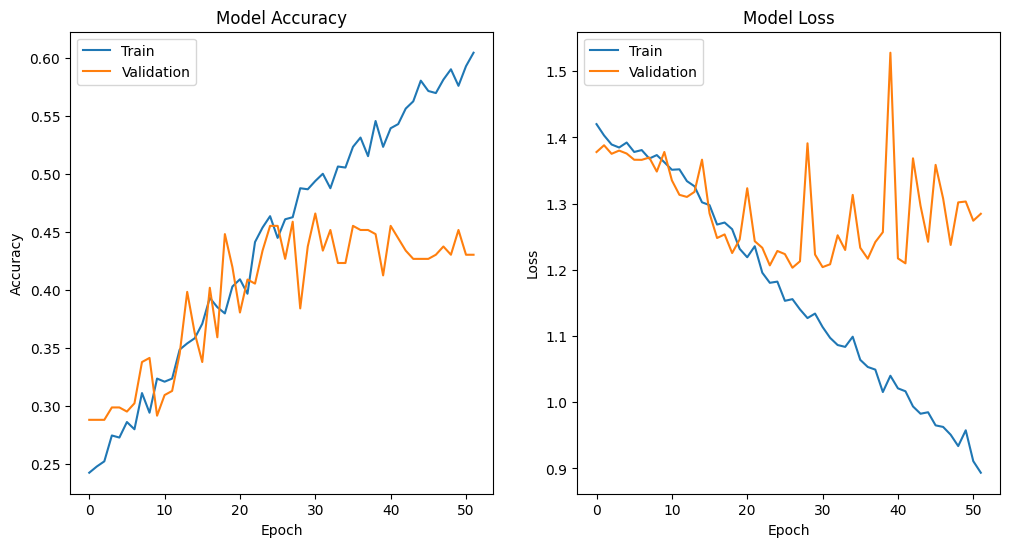

In [34]:
# Plot accuracy graphs
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In this code:

We load the pre-trained VGG16 model without the fully connected layers (top layers).
We freeze the weights of the pre-trained layers to keep the convolutional features fixed during training.
We add new layers on top of the pre-trained base model, including a Flatten layer, a Dense layer with ReLU activation, Dropout for regularization, and a final Dense layer with softmax activation.
The model is compiled using the Adam optimizer and categorical crossentropy loss.
The model is trained on your dataset for 10 epochs with a batch size of 32 and a validation split of 20%.
Finally, we evaluate the model on the test set and print the test loss and accuracy.
we can adjust the number of epochs, learning rate, and other hyperparameters based on the performance and convergence of the model.

In [35]:
model.save('/kaggle/working/kinship_modelv16.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [36]:
# Load the saved model
#loaded_model = load_model('/kaggle/working/kinship_model.h5')

In [37]:

# Import necessary libraries
from keras.applications import InceptionV3
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

# Load InceptionV3 pre-trained on ImageNet data
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Set all layers in the base model to non-trainable
for layer in base_model.layers:
    layer.trainable = False

# Create a new model
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

# Set up early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)
lr_scheduler = LearningRateScheduler(lr_schedule)
# Train the model with augmented data
history = model.fit(datagen.flow(X_train, y_train_one_hot, batch_size=42),
                    epochs=150,
                    validation_data=(X_test, y_test_one_hot),
                    callbacks=[early_stop, lr_scheduler])

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test_one_hot)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Save the model
model.save('/kaggle/working/kinship_model_inception.h5')

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_12 (Dense)            (None, 1024)              2098176   
                                                                 
 dropout_8 (Dropout)         (None, 1024)              0         
                                                                 
 dense_13 (Dense)            (None, 512)               524800    
                                                                 
 dropout_9 (Dropout)         (None, 512)               0         
                                                      

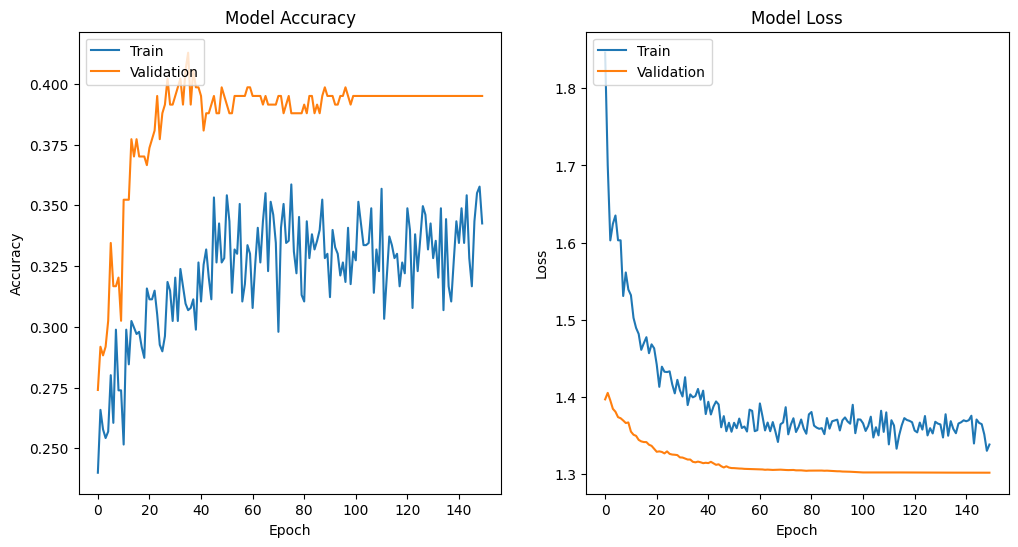

In [38]:
# Plot accuracy graphs
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [39]:

from keras.applications import VGG19

base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Set the layers in the base model to be trainable
for layer in base_model.layers:
    layer.trainable = True

model = Sequential()
model.add(base_model)
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

# Train the model with augmented data
history = model.fit(datagen.flow(X_train, y_train_one_hot, batch_size=40), epochs=150, validation_data=(X_test, y_test_one_hot), callbacks=[early_stop])

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test_one_hot)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 conv2d_197 (Conv2D)         (None, 7, 7, 512)         2359808   
                                                                 
 conv2d_198 (Conv2D)         (None, 7, 7, 512)         2359808   
                                                                 
 conv2d_199 (Conv2D)         (None, 7, 7, 512)         2359808   
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 3, 3, 512)         0         
 ng2D)                                                           
                                                                 
 flatten_3 (Flatten)         (None, 4608)              0         
                                                      

In [40]:
model.save('/kaggle/working/kinship_modelv19.h5')

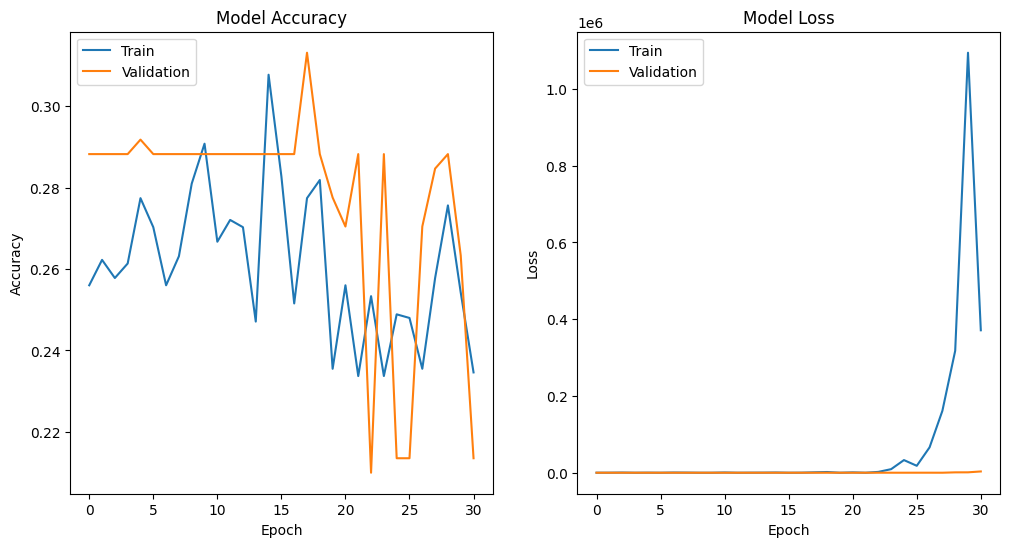

In [41]:
# Plot accuracy graphs
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [42]:
import numpy as np
from keras.applications import Xception
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator

# Set the number of classes
num_classes = 4

# Load Xception pre-trained on ImageNet data
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Set all layers in the base model to non-trainable
for layer in base_model.layers:
    layer.trainable = False

# Create a new model
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
initial_learning_rate = 1e-4
model.compile(optimizer=Adam(learning_rate=initial_learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

# Learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * np.exp(-0.1)

# Set up early stopping and learning rate scheduler callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)
lr_schedule = LearningRateScheduler(lr_scheduler)

# Create an instance of ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the model with augmented data
history = model.fit(datagen.flow(X_train, y_train_one_hot, batch_size=42),
                    epochs=1000,
                    validation_data=(X_test, y_test_one_hot),
                    callbacks=[early_stop, lr_schedule])

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test_one_hot)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Save the model
model.save('/kaggle/working/kinship_model_xception.h5')

# Load the saved model
loaded_model = load_model('/kaggle/working/kinship_model_xception.h5')


83683744/83683744 [==============================] - 0s 0us/step
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_18 (Dense)            (None, 1024)              2098176   
                                                                 
 dropout_12 (Dropout)        (None, 1024)              0         
                                                                 
 dense_19 (Dense)            (None, 512)               524800    
                                                                 
 dropout_13 (Dropout)        (None, 512)               

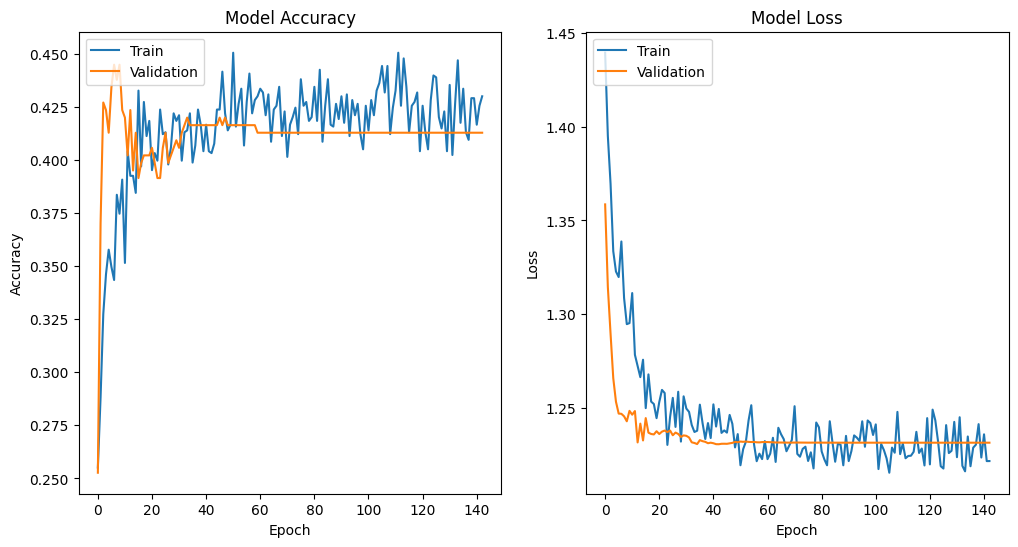

In [43]:
# Plot accuracy graphs
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [44]:

from keras.preprocessing import image
import numpy as np

# Load the saved model
loaded_model = load_model('kaggle/working/kinship_model.h5')

def preprocess_image(img_path):
    # Load and preprocess an image for model prediction
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array

def predict_relationship(img_path1, img_path2):
    # Preprocess images
    img_array1 = preprocess_image(img_path1)
    img_array2 = preprocess_image(img_path2)

    # Make predictions for both images
    prediction1 = loaded_model.predict(img_array1)
    prediction2 = loaded_model.predict(img_array2)

    # Calculate the similarity score (you can define your own logic here)
    similarity_score = np.dot(prediction1, prediction2.T)

    # Print the similarity score
    print(f"Similarity Score: {similarity_score[0][0]}")

    # Define a threshold to classify as related or not
    threshold = 0.4
    if similarity_score > threshold:
        print("Images are related.")
    else:
        print("Images are not related.")

# Example usage:
image_path1 = '/kaggle/input/input-data/Kin+O-1/father-daughter/fd_001_1.jpg'
image_path2 = '/kaggle/input/input-data/Kin+O-1/father-daughter/fd_001_2.jpg'

predict_relationship(image_path1, image_path2)


OSError: No file or directory found at kaggle/working/kinship_model.h5